Files already downloaded and verified
Files already downloaded and verified


/home/ahmedekshazly/anaconda3/envs/gpu-env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ahmedekshazly/anaconda3/envs/gpu-env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ahmedekshazly/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


Total Parameters: 11,227,812
Trainable Parameters: 11,227,812

 Model Complexity:
MACs: 37.29 MMac | FLOPs: 2*37.29 MMac | Params: 11.23 M

 Training started...

Epoch [1/10], Train Loss: 2.9090, Val Loss: 2.4097, Val Acc: 37.36%, Epoch Time: 17.14s
Epoch [2/10], Train Loss: 2.1451, Val Loss: 2.0509, Val Acc: 44.85%, Epoch Time: 17.23s
Epoch [3/10], Train Loss: 1.7872, Val Loss: 2.0379, Val Acc: 47.02%, Epoch Time: 17.11s
Epoch [4/10], Train Loss: 1.5610, Val Loss: 1.9787, Val Acc: 49.02%, Epoch Time: 17.29s
Epoch [5/10], Train Loss: 1.3474, Val Loss: 1.9707, Val Acc: 50.00%, Epoch Time: 16.90s
Epoch [6/10], Train Loss: 1.1224, Val Loss: 1.9287, Val Acc: 51.33%, Epoch Time: 17.30s
Epoch [7/10], Train Loss: 0.9360, Val Loss: 2.0451, Val Acc: 51.06%, Epoch Time: 17.06s
Epoch [8/10], Train Loss: 0.8130, Val Loss: 2.1129, Val Acc: 51.34%, Epoch Time: 16.88s
Epoch [9/10], Train Loss: 0.6655, Val Loss: 2.1438, Val Acc: 51.27%, Epoch Time: 17.14s
Epoch [10/10], Train Loss: 0.5558, Val Loss: 2

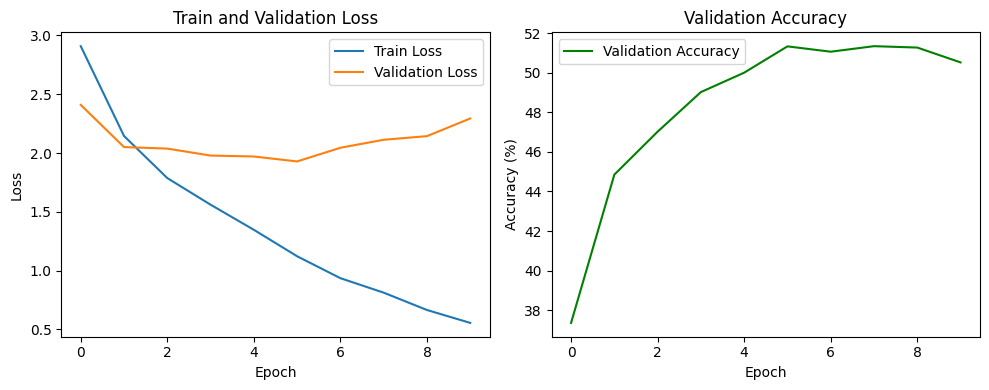

In [1]:
import time
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchinfo import summary
from ptflops import get_model_complexity_info

# Device configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
image_size = 32
num_classes = 100  # CIFAR-100 has 100 classes
num_epochs = 10
batch_size = 64
learning_rate = 0.001

# Data preparation
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-100 dataset
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Load pretrained ResNet-18
model = torchvision.models.resnet18(pretrained=True)

# Modify the final layer to match the number of CIFAR-100 classes (100)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to device
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation tracking
train_losses = []
val_losses = []
val_accuracies = []
epoch_times = []

def evaluate():
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def train():
    total_start = time.time()
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        val_loss, val_acc = evaluate()

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Acc: {val_acc:.2f}%, "
              f"Epoch Time: {epoch_time:.2f}s")

    total_time = time.time() - total_start
    print(f"\nTotal Training Time: {total_time:.2f}s")
    print(f"Average Epoch Time: {sum(epoch_times) / len(epoch_times):.2f}s")

if __name__ == '__main__':
    # Model summary
    info = summary(model, input_size=(batch_size, 3, image_size, image_size), device=device, verbose=0)
    total_params = info.total_params
    trainable_params = info.trainable_params

    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    
    # Model complexity
    macs, params = get_model_complexity_info(model, (3, image_size, image_size), as_strings=True,
                                             print_per_layer_stat=False, verbose=False)
    print(f"\n Model Complexity:\nMACs: {macs} | FLOPs: 2*{macs} | Params: {params}")

    print("\n Training started...\n")
    train()

    # Plotting
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
